In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from uncertainties import ufloat
from ctypes import c_double

import ROOT
import math
ROOT.EnableImplicitMT()    # Tells ROOT to go parallel

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Welcome to JupyROOT 6.28/00


In [2]:
import os

# unique_dir = "vtx_PART_770_epoch_83_ML4_v2"
unique_dir = "vtx_PART_859_epoch_87_test1"

# ------------------------------------------------
sig_tag  = 'stop_M600_585_ct20_2018'




histname = "leading_vtx_ML1_vs_leading_vtx_ML2"
tdir     = "SP1_evt"
# tdir     = "all_evt"




bkg_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/bkg"
sig_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/sig"



sig_file = ROOT.TFile(os.path.join(sig_dir, f"{sig_tag}_hist.root"))
sig_dir  = getattr(sig_file, tdir)
sig_hist = getattr(sig_dir, histname).Clone()


bkg_file = ROOT.TFile(os.path.join(bkg_dir, f"all_2018_hist.root"))
bkg_dir  = getattr(bkg_file, tdir)
bkg_hist = getattr(bkg_dir, histname).Clone()

In [3]:
x_binwidth = sig_hist.GetXaxis().GetBinWidth(1)
y_binwidth = sig_hist.GetYaxis().GetBinWidth(1)

In [4]:
xax = sig_hist.GetXaxis()
yax = sig_hist.GetYaxis()

x_min = xax.GetBinLowEdge(1)
x_max = xax.GetBinUpEdge(xax.GetLast())

y_min = yax.GetBinLowEdge(1)
y_max = yax.GetBinUpEdge(yax.GetLast())

print(x_min, x_max, x_binwidth)
print(y_min, y_max, y_binwidth)

0.0 1.0 0.005
0.0 1.0 0.005


In [5]:
MET_boundaryList     = np.arange(x_min + x_binwidth, x_max, x_binwidth)
MLScore_boundaryList = np.arange(y_min + y_binwidth, y_max, y_binwidth)

In [6]:
MET_step = MET_boundaryList[1] - MET_boundaryList[0]
MLScore_step = MLScore_boundaryList[1] - MLScore_boundaryList[0]

# print(MET_boundaryList)
# print(MLScore_boundaryList)

MLScore_min = bkg_hist.GetYaxis().FindBin(0.50)

In [7]:
def calc_unc(region, region_unc, x_boundary, y_boundary, tables, noncl=None):
    unc1 = tables[region].loc[x_boundary, y_boundary] * 0.20
    unc2 = tables[region].loc[x_boundary, y_boundary] * noncl if noncl else 0.
    unc3 = tables[region_unc].loc[x_boundary, y_boundary]
    total_unc = np.sqrt(unc1**2 + unc2**2 + unc3**2)
    return total_unc

In [8]:
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)

def makeTables(
        xedges: np.ndarray,
        yedges: np.ndarray,
        bkg_hist: ROOT.TH2,
        sig_hist: ROOT.TH2,
        x_loCut: float = 0.0,
        y_loCut: float = 0.0,
        sigScale: float = 1.0,
        bkgScale: float = 1.0,
):
    x_step = xedges[1] - xedges[0]
    y_step = yedges[1] - yedges[0]
    empty_df = pd.DataFrame(index=np.arange(xedges[0], xedges[-1]+x_step, x_step),
                            columns=np.arange(yedges[0], yedges[-1]+y_step, y_step),
                            dtype= float)

    # Create empty tables
    tableNames = ['sig_NA', 'sig_NB', 'sig_NC', 'sig_ND',
                  'bkg_NA', 'bkg_NB', 'bkg_NC', 'bkg_ND',
                  'sig_NA_unc', 'sig_NB_unc', 'sig_NC_unc', 'sig_ND_unc',
                  'bkg_NA_unc', 'bkg_NB_unc', 'bkg_NC_unc', 'bkg_ND_unc',
                  'Z_A', 'Z_B', 'Z_C', 'Z_D',
                  'Z_noncl_A', 'Z_noncl_B', 'Z_noncl_C', 'Z_noncl_D',
                  'Z_noncl_plus1s_A', 'Z_noncl_plus1s_B', 'Z_noncl_plus1s_C', 'Z_noncl_plus1s_D',
                  'noncl', 'noncl_unc',
                ]
    tables = dict()
    for name in tableNames:
        tables[name] = empty_df.copy()
     
    for x_boundary in xedges:
        for y_boundary in yedges:
            x_lo    = bkg_hist.GetXaxis().FindBin(x_loCut)
            x_up    = bkg_hist.GetNbinsX()+1
            x_bound = bkg_hist.GetXaxis().FindBin(x_boundary)

            y_lo    = bkg_hist.GetYaxis().FindBin(y_loCut)
            y_up    = bkg_hist.GetNbinsY()+1
            y_bound = bkg_hist.GetYaxis().FindBin(y_boundary)


            # ------------ Backgrounds --------------
            c_err = c_double(0.0)
            NA = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NB = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NC = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale
            ND = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale

            num   = NB * NC
            denom = NA * ND
            noncl = np.abs(1- num/denom) if denom.n > 0 else ufloat(1e-5, 1e-5)

            eps = 5e-1

            tables['bkg_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['bkg_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['bkg_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['bkg_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['bkg_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['bkg_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['bkg_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['bkg_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)

            tables['noncl'].loc[x_boundary, y_boundary]     = noncl.n
            tables['noncl_unc'].loc[x_boundary, y_boundary] = noncl.s
            

            # ------------ Signals --------------
            c_err = c_double(0.0)
            NA = ufloat(sig_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * sigScale
            NB = ufloat(sig_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * sigScale
            NC = ufloat(sig_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * sigScale
            ND = ufloat(sig_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * sigScale

            eps = 5e-1

            tables['sig_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['sig_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['sig_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['sig_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['sig_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['sig_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['sig_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['sig_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)

            # ------------ Significance --------------

            Z_A      = ROOT.RooStats.AsimovSignificance(tables['sig_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NA', 'bkg_NA_unc', x_boundary, y_boundary, tables))
            Z_B      = ROOT.RooStats.AsimovSignificance(tables['sig_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NB', 'bkg_NB_unc', x_boundary, y_boundary, tables))
            Z_C      = ROOT.RooStats.AsimovSignificance(tables['sig_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NC', 'bkg_NC_unc', x_boundary, y_boundary, tables))
            Z_D      = ROOT.RooStats.AsimovSignificance(tables['sig_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_ND', 'bkg_ND_unc', x_boundary, y_boundary, tables))

            
            tables['Z_A'].loc[x_boundary, y_boundary] = Z_A
            tables['Z_B'].loc[x_boundary, y_boundary] = Z_B
            tables['Z_C'].loc[x_boundary, y_boundary] = Z_C
            tables['Z_D'].loc[x_boundary, y_boundary] = Z_D

            # ------------ Significance with non-clsoure uncertainty --------------

            Z_A      = ROOT.RooStats.AsimovSignificance(tables['sig_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NA', 'bkg_NA_unc', x_boundary, y_boundary, tables, noncl.n))
            Z_B      = ROOT.RooStats.AsimovSignificance(tables['sig_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NB', 'bkg_NB_unc', x_boundary, y_boundary, tables, noncl.n))
            Z_C      = ROOT.RooStats.AsimovSignificance(tables['sig_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NC', 'bkg_NC_unc', x_boundary, y_boundary, tables, noncl.n))
            Z_D      = ROOT.RooStats.AsimovSignificance(tables['sig_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_ND', 'bkg_ND_unc', x_boundary, y_boundary, tables, noncl.n))

            
            tables['Z_noncl_A'].loc[x_boundary, y_boundary] = Z_A
            tables['Z_noncl_B'].loc[x_boundary, y_boundary] = Z_B
            tables['Z_noncl_C'].loc[x_boundary, y_boundary] = Z_C
            tables['Z_noncl_D'].loc[x_boundary, y_boundary] = Z_D

            # ------------ Significance with non-clsoure uncertainty plus one sigma unc. -------

            Z_A      = ROOT.RooStats.AsimovSignificance(tables['sig_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NA', 'bkg_NA_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))
            Z_B      = ROOT.RooStats.AsimovSignificance(tables['sig_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NB', 'bkg_NB_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))
            Z_C      = ROOT.RooStats.AsimovSignificance(tables['sig_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NC', 'bkg_NC_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))
            Z_D      = ROOT.RooStats.AsimovSignificance(tables['sig_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_ND', 'bkg_ND_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))

            
            tables['Z_noncl_plus1s_A'].loc[x_boundary, y_boundary] = Z_A
            tables['Z_noncl_plus1s_B'].loc[x_boundary, y_boundary] = Z_B
            tables['Z_noncl_plus1s_C'].loc[x_boundary, y_boundary] = Z_C
            tables['Z_noncl_plus1s_D'].loc[x_boundary, y_boundary] = Z_D
            
    return tables

In [9]:
# tables['sig_NA']

In [10]:
tables = makeTables(
    MET_boundaryList,
    MLScore_boundaryList,
    bkg_hist,
    sig_hist,
    x_loCut = x_min,
    y_loCut = y_min,
    sigScale = 1.0,
    bkgScale = 1.0,
)

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [11]:
for key in tables.keys():
    print(key)

sig_NA
sig_NB
sig_NC
sig_ND
bkg_NA
bkg_NB
bkg_NC
bkg_ND
sig_NA_unc
sig_NB_unc
sig_NC_unc
sig_ND_unc
bkg_NA_unc
bkg_NB_unc
bkg_NC_unc
bkg_ND_unc
Z_A
Z_B
Z_C
Z_D
Z_noncl_A
Z_noncl_B
Z_noncl_C
Z_noncl_D
Z_noncl_plus1s_A
Z_noncl_plus1s_B
Z_noncl_plus1s_C
Z_noncl_plus1s_D
noncl
noncl_unc


In [12]:
noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

Z = tables['Z_A']
Z_noncl = tables['Z_noncl_A']
Z_noncl_plus1s = tables['Z_noncl_plus1s_A']

In [13]:
# import matplotlib.pyplot as plt

# plt.title(sig_tag)
# pcm = plt.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis')
# cbar = plt.colorbar(pcm)
# cbar.ax.set_ylabel('Asimov Significance')
# levels = [4, 8, 12]
# levels = [lv for lv in levels if lv <= np.nanmax(Z.values)]
# if levels:
#     cont = plt.contour(Z.index, Z.columns, Z.T, levels=levels, colors="white", linewidths=1.0)
#     plt.clabel(cont, fontsize="smaller")
# plt.ylim(0.9, 1.0)
# plt.xlabel('MET cut [GeV]')
# plt.ylabel('Max ParT score cut')
# plt.show()

In [13]:
# import matplotlib.pyplot as plt

# plt.title(sig_tag)
# pcm = plt.pcolormesh(Z_noncl.index, Z_noncl.columns, Z_noncl.T, cmap='viridis')
# cbar = plt.colorbar(pcm)
# cbar.ax.set_ylabel('Asimov Significance')
# levels = [4, 8, 12]
# levels = [lv for lv in levels if lv <= np.nanmax(Z.values)]
# if levels:
#     cont = plt.contour(Z_noncl.index, Z_noncl.columns, Z_noncl.T, levels=levels, colors="white", linewidths=1.0)
#     plt.clabel(cont, fontsize="smaller")
# plt.ylim(0.9, 1.0)
# plt.xlabel('MET cut [GeV]')
# plt.ylabel('Max ParT score cut')
# plt.show()

In [14]:
tables['noncl']

,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,0.050,...,0.950,0.955,0.960,0.965,0.970,0.975,0.980,0.985,0.990,0.995
0.005,0.00001,0.00001,1.171094,0.607672,0.766407,0.795381,0.795381,0.817076,0.827058,0.812143,...,0.946629,0.938097,0.914826,0.983828,0.983540,0.975131,0.981284,0.960981,1.000000,1.000000
0.010,0.00001,0.00001,0.025286,0.280713,0.482778,0.587029,0.587029,0.597145,0.604475,0.572719,...,0.849087,0.825817,0.722057,0.699620,0.652439,0.964081,0.942739,0.981110,0.980397,1.000000
0.015,0.00001,0.00001,0.533265,0.339705,0.475647,0.489762,0.489762,0.487243,0.481014,0.450921,...,0.841000,0.832058,0.741197,0.741013,0.705961,0.913707,0.918713,0.979125,0.956435,0.277524
0.020,0.00001,0.00001,0.647546,0.355116,0.433572,0.474362,0.474362,0.448314,0.433266,0.398048,...,0.845456,0.829394,0.749021,0.766661,0.746514,0.927978,0.978825,0.984064,0.966743,0.448471
0.025,0.00001,0.00001,0.603165,0.261602,0.359773,0.419747,0.419747,0.396710,0.381350,0.347303,...,0.835386,0.815608,0.756602,0.761581,0.734508,0.876462,0.895894,0.895719,0.971880,0.533657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.975,0.00001,0.00001,11.759086,23.163126,18.235226,11.845877,11.845877,8.405264,8.273783,7.989455,...,0.168314,0.299978,0.473868,0.565697,0.596975,0.237446,2.336161,0.600166,0.000010,0.000010
0.980,0.00001,0.00001,18.047090,22.271361,20.563175,12.949042,12.949042,7.903227,8.841804,7.377579,...,0.407278,0.524294,0.654274,0.699556,0.681146,0.000010,0.000010,0.000010,0.000010,0.000010
0.985,0.00001,0.00001,1.000000,0.661866,0.904084,1.062411,1.062411,0.975384,0.959567,0.728164,...,0.620500,0.677292,0.765425,0.765665,0.236879,0.000010,0.000010,0.000010,0.000010,0.000010
0.990,0.00001,0.00001,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010


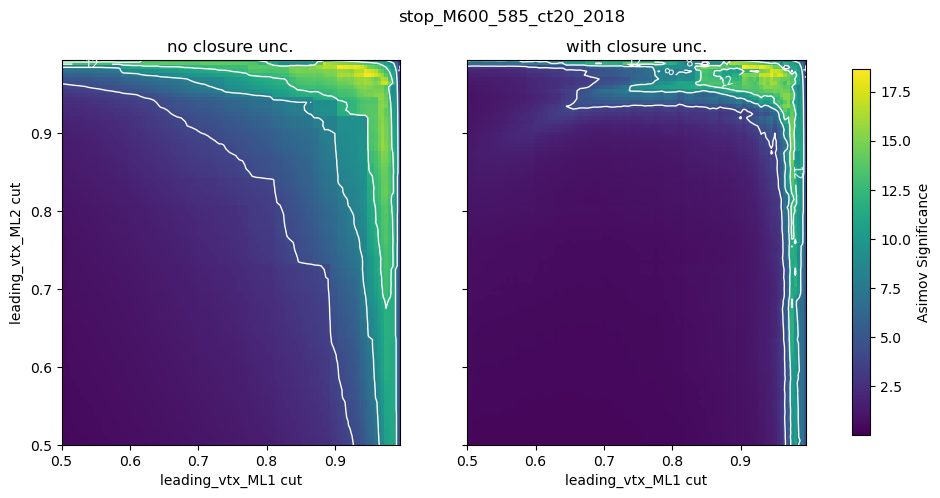

In [18]:
import numpy as np
import matplotlib.pyplot as plt

noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

Z = tables['Z_A']
Z_noncl = tables['Z_noncl_A']
Z_noncl_plus1s = tables['Z_noncl_plus1s_A']




# Common levels based on both matrices
base_levels = [4, 8, 12]
global_max = np.nanmax([np.nanmax(Z.values), np.nanmax(Z_noncl.values)])
levels = [lv for lv in base_levels if lv <= global_max]

# Consistent color scale across both plots
vmin = np.nanmin([np.nanmin(Z.values), np.nanmin(Z_noncl.values)])
vmax = global_max

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

fig.suptitle(sig_tag)

# --- Left: Z ---
ax = axes[0]
ax.set_title(f"no closure unc.")
pcm0 = ax.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont0 = ax.contour(Z.index, Z.columns, Z.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont0, fontsize="smaller")
ax.set_xlim(0.5, Z_noncl.index.max())
ax.set_ylim(0.5, Z_noncl.columns.max())
ax.set_xlabel('leading_vtx_ML1 cut')
ax.set_ylabel('leading_vtx_ML2 cut')

# --- Right: Z_noncl ---
ax = axes[1]
ax.set_title(f"with closure unc.")
pcm1 = ax.pcolormesh(Z_noncl.index, Z_noncl.columns, Z_noncl.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont1 = ax.contour(Z_noncl.index, Z_noncl.columns, Z_noncl.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont1, fontsize="smaller")
ax.set_xlim(0.5, Z_noncl.index.max())
ax.set_ylim(0.5, Z_noncl.columns.max())
ax.set_xlabel('leading_vtx_ML1 cut')

# Shared colorbar
cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), shrink=0.95)
cbar.ax.set_ylabel('Asimov Significance')

# plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --- noncl ---
# Z   = tables['noncl']
# Z1s = tables['noncl'] + tables['noncl_unc']

Z   = myDict['0.50']['noncl']
Z1s = myDict['0.50']['noncl'] + myDict['0.50']['noncl_unc']

# Common levels based on both matrices
# Contour levels (clip to the data range so contour() doesn't warn)
base_levels = [0.20, 0.50]
zmax = max(np.nanmax(Z.values), np.nanmax(Z1s.values))
levels = [lv for lv in base_levels if lv <= zmax]

vmin = 0
vmax = 1

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("2018 MC bkg")

# --- Left: Z ---
ax = axes[0]
ax.set_title(r"noncl (nom.)")
pcm0 = ax.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont0 = ax.contour(Z.index, Z.columns, Z.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont0, fontsize="smaller")
ax.set_xlim(0.8, Z_noncl.index.max())
ax.set_ylim(0.5, Z_noncl.columns.max())
ax.set_xlabel('leading_vtx_ML1 cut')
ax.set_ylabel('leading_vtx_ML2 cut')

# --- Right: Z_noncl ---
ax = axes[1]
ax.set_title(r"noncl (+1$\sigma$)")
pcm1 = ax.pcolormesh(Z1s.index, Z1s.columns, Z1s.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont1 = ax.contour(Z1s.index, Z1s.columns, Z1s.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont1, fontsize="smaller")
ax.set_xlim(0.8, Z_noncl.index.max())
ax.set_ylim(0.5, Z_noncl.columns.max())
ax.set_xlabel('leading_vtx_ML1 cut')

# Shared colorbar
cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), shrink=0.95)
cbar.ax.set_ylabel('non-closure')

# plt.tight_layout()
plt.show()


NameError: name 'myDict' is not defined

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.ndimage

# --- noncl ---
Z   = myDict['0.50']['noncl'] / myDict['0.50']['noncl_unc']

us = 2 # upsampling rate
Z_smooth = Z.loc[:,0.90:]
Z_smooth_x = scipy.ndimage.zoom(Z_smooth.index, us, mode='nearest')
Z_smooth_y = scipy.ndimage.zoom(Z_smooth.columns, us, mode='nearest')
Z_smooth = scipy.ndimage.zoom(Z_smooth, us)

# Common levels based on both matrices
# Contour levels (clip to the data range so contour() doesn't warn)
base_levels = [1.5]
zmax = max(np.nanmax(Z.values), np.nanmax(Z1s.values))
levels = [lv for lv in base_levels if lv <= zmax]

vmin = 0
vmax = 5

fig, ax = plt.subplots(1,1, figsize=(6, 6), sharey=True)
fig.suptitle("2018 MC bkg")
ax.set_title(r"noncl significance")
pcm0 = ax.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont0 = ax.contour(Z_smooth_x, Z_smooth_y, Z_smooth.T, levels=levels, colors="white", linewidths=1)
    ax.clabel(cont0, fontsize="smaller")
ax.set_ylim(0.9, Z_noncl.columns.max())
ax.set_xlabel('MET cut [GeV]')
ax.set_ylabel('Max ParT score cut')

# Shared colorbar
cbar = fig.colorbar(pcm0, ax=ax, shrink=0.95)
cbar.ax.set_ylabel('non-closure')

# plt.tight_layout()
plt.show()


NameError: name 'myDict' is not defined

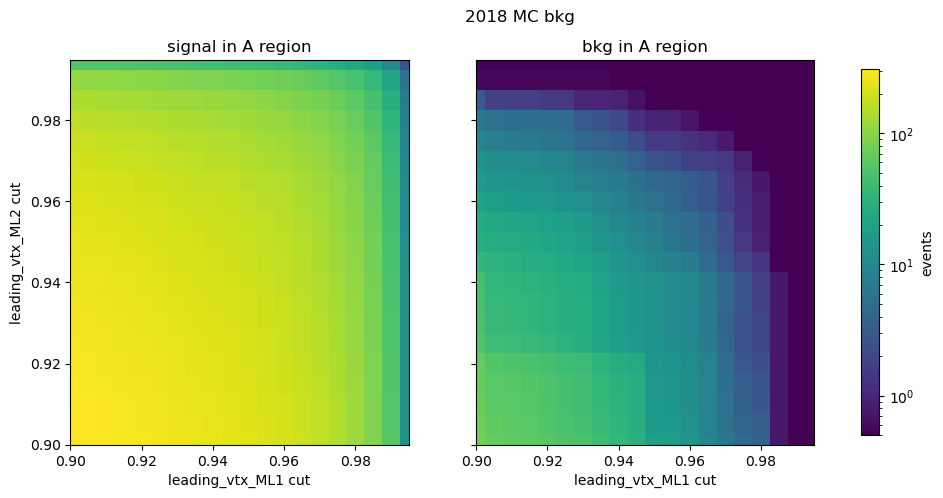

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

x_min = 0.90
y_min = 0.90
sig_A = tables['sig_NA'].loc[x_min:, y_min:]
bkg_A = tables['bkg_NA'].loc[x_min:, y_min:]

# Shared normalization across both plots
vmin = min(sig_A.min().min(), bkg_A.min().min())
vmax = max(sig_A.max().max(), bkg_A.max().max())
norm = LogNorm(vmin=max(vmin, 1e-3), vmax=vmax)  # guard against zeros

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("2018 MC bkg")

# --- Left: sig_A ---
ax = axes[0]
ax.set_title("signal in A region")
pcm0 = ax.pcolormesh(sig_A.index, sig_A.columns, sig_A.T,
                     cmap='viridis', shading='auto', norm=norm)
ax.set_xlim(x_min, sig_A.index.max())
ax.set_ylim(y_min, sig_A.columns.max())
ax.set_xlabel('leading_vtx_ML1 cut')
ax.set_ylabel('leading_vtx_ML2 cut')

# --- Right: bkg_A ---
ax = axes[1]
ax.set_title("bkg in A region")
pcm1 = ax.pcolormesh(bkg_A.index, bkg_A.columns, bkg_A.T,
                     cmap='viridis', shading='auto', norm=norm)
ax.set_xlim(x_min, sig_A.index.max())
ax.set_ylim(y_min, bkg_A.columns.max())
ax.set_xlabel('leading_vtx_ML1 cut')

# Shared colorbar (both share the same norm)
cbar = fig.colorbar(pcm1, ax=axes, shrink=0.95)
cbar.ax.set_ylabel('events')

plt.show()


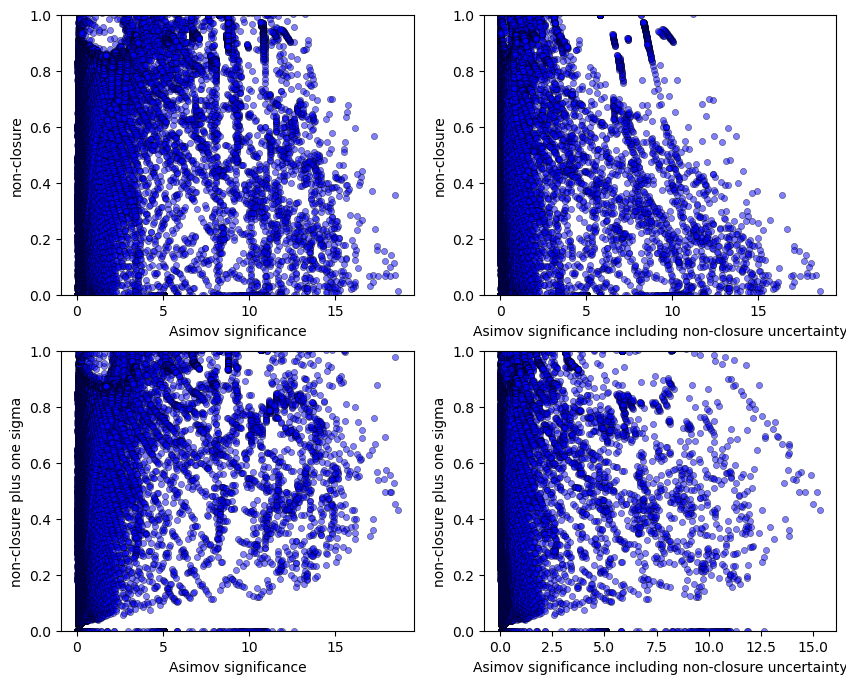

In [20]:
import matplotlib.pyplot as plt

noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

Z = tables['Z_A']
Z_noncl = tables['Z_noncl_A']
Z_noncl_plus1s = tables['Z_noncl_plus1s_A']

fig, axs = plt.subplots(2,2, figsize=(10,8))
for col in Z.columns:
    axs[0,0].scatter(Z[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[0,0].set_title("")
axs[0,0].set_ylim(0.0, 1.0)
axs[0,0].set_xlabel('Asimov significance')
axs[0,0].set_ylabel('non-closure')

for col in Z.columns:
    axs[1,0].scatter(Z[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[1,0].set_title("")
axs[1,0].set_ylim(0.0, 1.0)
axs[1,0].set_xlabel('Asimov significance')
axs[1,0].set_ylabel('non-closure plus one sigma')

for col in Z.columns:
    axs[0,1].scatter(Z_noncl[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[0,1].set_title("")
axs[0,1].set_ylim(0.0, 1.0)
axs[0,1].set_xlabel('Asimov significance including non-closure uncertainty')
axs[0,1].set_ylabel('non-closure')

for col in Z.columns:
    axs[1,1].scatter(Z_noncl_plus1s[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[1,1].set_title("")
axs[1,1].set_ylim(0.0, 1.0)
axs[1,1].set_xlabel('Asimov significance including non-closure uncertainty')
axs[1,1].set_ylabel('non-closure plus one sigma')

plt.show()


In [28]:
# noncl_plus1s
# import matplotlib.pyplot as plt
# for col in Z.columns:
#     plt.scatter(Z[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
# plt.xlabel('significance')
# plt.ylabel('non-closure')
# plt.ylim(0.0, 1.0)
# plt.show()

In [124]:
# noncl_plus1s
# import matplotlib.pyplot as plt
# for col in Z.columns:
#     plt.scatter(Z_noncl[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
# plt.xlabel('significance')
# plt.ylabel('non-closure')
# plt.ylim(0.0, 1.0)
# plt.show()

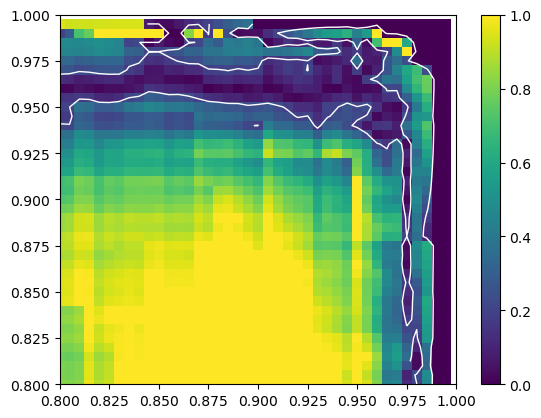

In [26]:
import matplotlib.pyplot as plt
noncl = tables['noncl']

pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
plt.clim(0, 1)
levels = [0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.xlim(0.8, 1.0)
plt.ylim(0.8, 1.0)
plt.show()

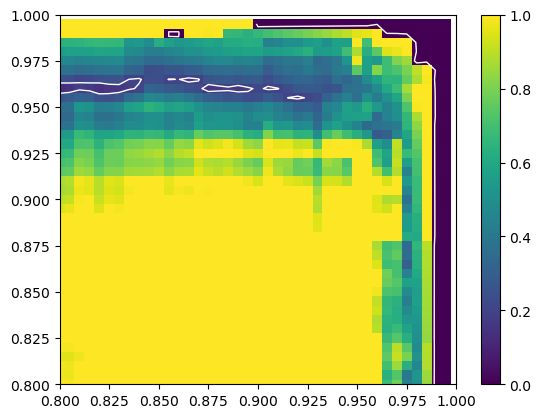

In [27]:
import matplotlib.pyplot as plt
noncl = tables['noncl'] + tables['noncl_unc']

pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
plt.clim(0, 1)
levels = [0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.xlim(0.8, 1.0)
plt.ylim(0.8, 1.0)
plt.show()

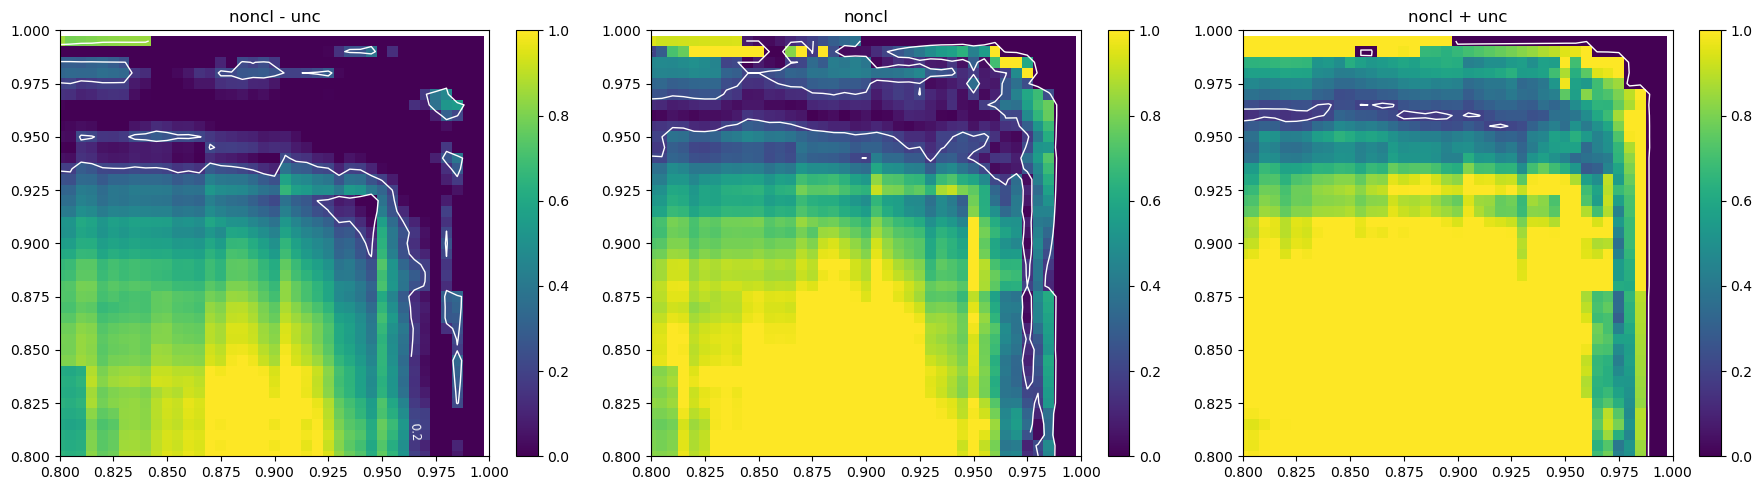

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_noncl(ax, arr, title):
    pcm = ax.pcolormesh(arr.index, arr.columns, arr.T, cmap='viridis')
    plt.colorbar(pcm, ax=ax)
    pcm.set_clim(0, 1)

    # contour
    levels = [0.20]
    levels = [lv for lv in levels if lv <= np.nanmax(arr.values)]
    if levels:
        cont = ax.contour(arr.index, arr.columns, arr.T,
                          levels=levels, colors="white", linewidths=1.0)
        ax.clabel(cont, fontsize="smaller")

    ax.set_xlim(0.8, 1.0)
    ax.set_ylim(0.8, 1.0)
    ax.set_title(title)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_noncl(axes[0], tables['noncl'] - tables['noncl_unc'], "noncl - unc")
plot_noncl(axes[1], tables['noncl'],                       "noncl")
plot_noncl(axes[2], tables['noncl'] + tables['noncl_unc'], "noncl + unc")

plt.tight_layout()
plt.show()


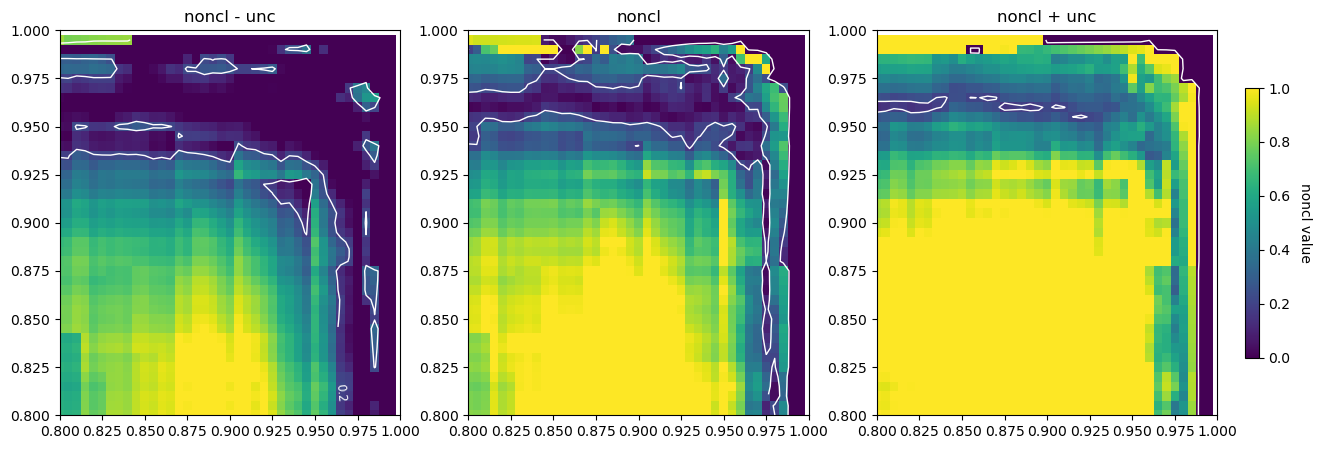

### Scan lower boundary as well 

In [43]:
y_loCut = [0.00, 0.30, 0.50, 0.80]
myDict = dict()
for y_cut in y_loCut:
    tables = makeTables(
        MET_boundaryList,
        MLScore_boundaryList,
        bkg_hist,
        sig_hist,
        x_loCut = x_min,
        y_loCut = y_cut,
        sigScale = 1.0,
        bkgScale = 1.0,
    )
    myDict[f"{y_cut:.2f}"] = tables

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with st

In [33]:
myDict['0.50']['noncl'].loc[:, float('0.50'):]

,0.500,0.505,0.510,0.515,0.520,0.525,0.530,0.535,0.540,0.545,...,0.950,0.955,0.960,0.965,0.970,0.975,0.980,0.985,0.990,0.995
0.005,0.0,0.000010,0.000010,0.000010,3.803779,2.793422,2.638814,3.268239,3.933294,4.591878,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
0.010,0.0,1.501880,1.316956,0.936161,1.083062,1.214079,1.096295,1.032296,0.895034,0.995754,...,3.045909,3.446875,3.837206,3.700024,3.595236,3.307857,2.232623,0.680307,1.000000,1.00000
0.015,0.0,0.025441,0.165858,0.266975,0.350618,0.420084,0.355617,0.400557,0.440822,0.431902,...,3.925603,4.723323,4.191864,4.204340,3.433675,2.775234,2.746544,1.063899,1.000000,1.00000
0.020,0.0,0.339229,0.346615,0.422336,0.331100,0.427177,0.376350,0.404714,0.449587,0.441117,...,3.763342,4.338026,4.227339,3.591387,3.080075,2.354424,2.678402,0.824558,0.945173,1.00000
0.025,0.0,0.351124,0.328753,0.347629,0.267967,0.342669,0.331621,0.330939,0.370800,0.387303,...,3.288143,3.687752,3.817795,3.343820,3.070169,2.449133,2.202244,0.337636,0.925372,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.975,0.0,0.668371,0.542163,0.587765,0.510347,0.481405,0.491702,0.426214,3.066416,2.782992,...,0.022394,0.096838,0.324209,0.535092,0.628731,0.726618,0.816265,0.915826,0.897881,0.00001
0.980,0.0,0.750037,0.637378,0.642224,0.561926,0.568554,0.596797,0.615283,5.440703,4.898262,...,0.034079,0.040281,0.143684,0.420111,0.562639,0.686611,0.814343,0.919052,0.929398,0.00001
0.985,0.0,0.600360,0.179363,0.042136,0.549940,0.480120,0.255035,0.173738,0.226963,0.133750,...,0.519579,0.537048,0.611582,0.743925,0.816964,0.855547,0.904199,0.959556,0.944572,0.00001
0.990,0.0,1.000000,0.072251,0.061378,1.477373,1.427430,1.018782,0.735135,0.798539,0.620378,...,0.250699,0.420529,0.570419,0.673966,0.636582,0.117587,0.571493,0.774399,0.941697,0.00001


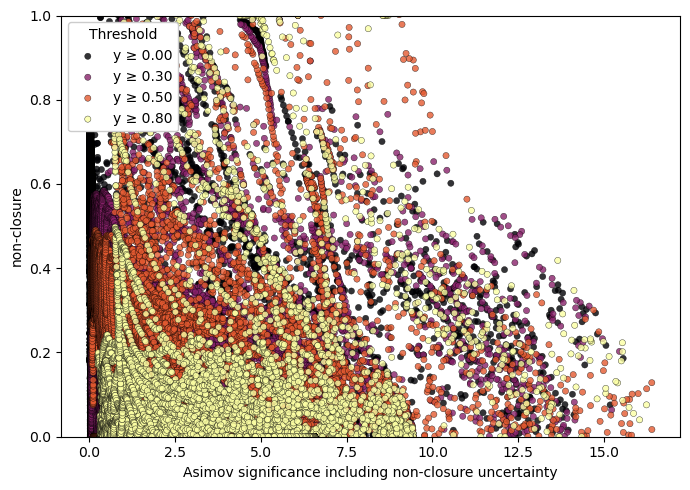

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


keys = myDict.keys()
ylos = [float(ylo) for ylo in keys]
norm = Normalize(vmin=min(ylos), vmax=max(ylos))

plt.figure(figsize=(7,5))

for ylo in myDict.keys():
    noncl = myDict[ylo]['noncl'].loc[:, float(ylo):]
    Z     = myDict[ylo]['Z_noncl_A']  .loc[:, float(ylo):]

    # Flatten all columns so we do one scatter per ylo (clean legend)
    x = Z.to_numpy().ravel(order='F')
    y = noncl.to_numpy().ravel(order='F')

    plt.scatter(
        x, y,
        alpha=0.8,
        c=np.ones_like(x) * float(ylo),
        s=20,
        edgecolors="k",
        linewidths=0.3,
        label=f"y ≥ {ylo}",
        cmap='inferno',
        norm=norm
    )

plt.title("")
plt.xlabel("Asimov significance including non-closure uncertainty")
plt.ylabel("non-closure")
plt.ylim(0.0, 1.0)
plt.legend(title="Threshold", frameon=True, loc='upper left', framealpha=1.0)
plt.tight_layout()
plt.show()


In [22]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



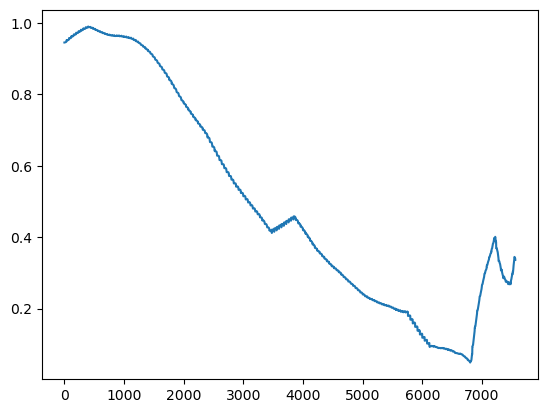

In [23]:
x = myDict[ylo]['noncl'].loc[:, float(ylo):].to_numpy().ravel()
y = moving_average(x, n=400)
leny = np.size(y)
plt.plot(y)

In [24]:
Z = myDict[ylo]['Z_A'].loc[:, float(ylo):].to_numpy().ravel()
Z

array([0.21641935, 0.22351127, 0.22964368, ..., 4.90147034, 4.10794821,
       2.58552495])

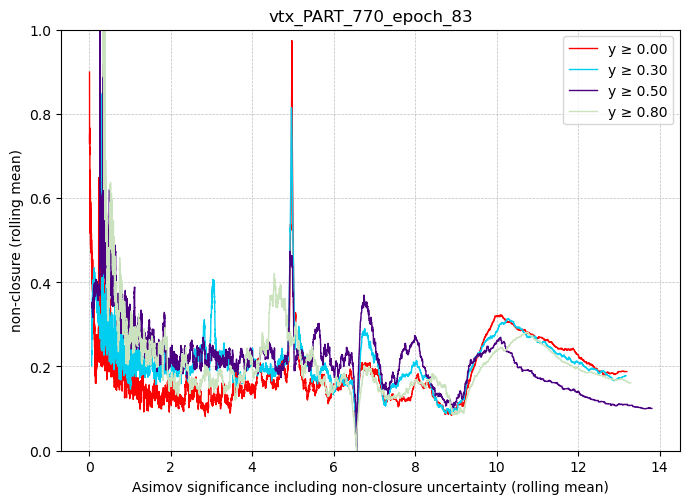

In [45]:
import numpy as np
import matplotlib.pyplot as plt

CB_color_cycle = ['red', '#00CEF1', 'indigo', '#CAE2BE']


plt.figure(figsize=(7,5))
for i, ylo in enumerate(myDict.keys()):
    # Flatten significance (X) and non-closure (Y)
    X = myDict[ylo]['Z_noncl_A']  .loc[:, float(ylo):].to_numpy().ravel(order='F')  # significance
    Y = myDict[ylo]['noncl'].loc[:, float(ylo):].to_numpy().ravel(order='F')  # non-closure

    # Drop NaNs and sort by significance
    m = np.isfinite(X) & np.isfinite(Y)
    X, Y = X[m], Y[m]
    order = np.argsort(X)
    Xs, Ys = X[order], Y[order]

    # Rolling mean with the SAME window on both X and Y
    n = 100  # your window
    kernel = np.ones(n) / n
    X_mean = np.convolve(Xs, kernel, mode='valid')
    Y_mean = np.convolve(Ys, kernel, mode='valid')
    plt.step(X_mean, Y_mean, lw=1., label=f"y ≥ {ylo}", color=CB_color_cycle[i])


from matplotlib import patheffects
plt.xlabel("Asimov significance including non-closure uncertainty (rolling mean)")
plt.ylabel("non-closure (rolling mean)")
plt.ylim(0, 1)
plt.tight_layout()
plt.legend()
plt.grid(color='gray', linestyle='dashed', alpha=0.5, lw=.5)
plt.title('vtx_PART_770_epoch_83')
plt.show()
